In [1]:
library(modelr)
library(tidyverse)

Warning message in system("timedatectl", intern = TRUE):
“running command 'timedatectl' had status 1”
── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.4.1     ✔ purrr   1.0.1
✔ tibble  3.2.1     ✔ dplyr   1.1.1
✔ tidyr   1.3.0     ✔ stringr 1.4.1
✔ readr   2.1.4     ✔ forcats 1.0.0

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()



# Lecture 20: Classification and logistic regression

<div style="border: 1px double black; padding: 10px; margin: 10px">

**After today's lecture you will understand:**
* Fitting logistic regression models in R using `glm()`.
* Use the fitted model to predict outcome for new dataset.
* Ways to measure the accuracy of a binary classifier.
</div>



## Modeling with categorical outcomes
Last lecture we learned all about regression. In regression, we have a continuous outcome (height, population growth, etc.), and some predictors which could be either categorical or continuous. We built a function that predicts the mean of the outcome given the predictors, e.g.

$$
\mathbb{E}(y \mid x) = a_0 + a_1 x.
$$

For example, we fit the following model:

In [2]:
lm(price ~ carat, diamonds) %>% summary


Call:
lm(formula = price ~ carat, data = diamonds)

Residuals:
     Min       1Q   Median       3Q      Max 
-18585.3   -804.8    -18.9    537.4  12731.7 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept) -2256.36      13.06  -172.8   <2e-16 ***
carat        7756.43      14.07   551.4   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 1549 on 53938 degrees of freedom
Multiple R-squared:  0.8493,	Adjusted R-squared:  0.8493 
F-statistic: 3.041e+05 on 1 and 53938 DF,  p-value: < 2.2e-16


This says that the average value of `log(price)` given `log(carat)` is 

$$8.449 + 1.676 \cdot \log(\text{carat})\quad\text{(avg. value of log(price))}$$

In today's lecture, we are going to look at a different kind of regression model, with the main difference being that our outcome is no longer a continuous variable like price or log(price). Instead, the outcome is a True/False variable which indicates whether or not some event happened.

## Deaths on the *RMS Titanic*
The [RMS Titanic](https://en.wikipedia.org/wiki/Titanic) famously sank on April 15, 1912 during its maiden voyage, killing about 2/3rds of its passengers. The `titanic` data set records the fates of everyone aboard.

In [3]:
data(Titanic)
titanic_df <- Titanic %>% as_tibble %>% mutate(Survived = Survived == "Yes") 
titanic_df <- titanic_df[rep(row.names(titanic_df), titanic_df$n), -5]
titanic_df %>% print

# A tibble: 2,201 × 4
   Class Sex   Age   Survived
   <chr> <chr> <chr> <lgl>   
 1 3rd   Male  Child FALSE   
 2 3rd   Male  Child FALSE   
 3 3rd   Male  Child FALSE   
 4 3rd   Male  Child FALSE   
 5 3rd   Male  Child FALSE   
 6 3rd   Male  Child FALSE   
 7 3rd   Male  Child FALSE   
 8 3rd   Male  Child FALSE   
 9 3rd   Male  Child FALSE   
10 3rd   Male  Child FALSE   
# ℹ 2,191 more rows


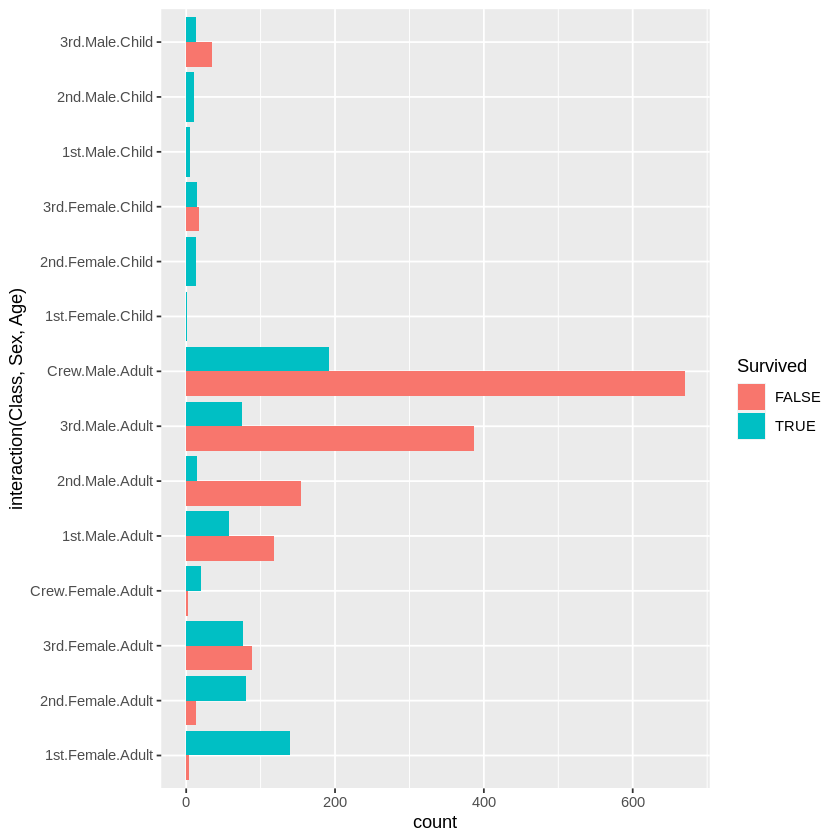

In [4]:
ggplot(titanic_df) + geom_bar(aes(x=interaction(Class, Sex, Age), fill=Survived), 
                              position='dodge') + coord_flip()

We have three categorical predictors: sex, age (adult / child), and class (1st-3rd or crew). Our outcome is also categorical: survived or not.

## Logistic regression
Suppose we want to build a regression model for predicting categorical outcomes.
In all of the regressions we have seen so far, the dependent ($y$) variable has been continuous: population growth, life expectancy, price, etc. However, there are many situations where the outcome is categorical. For simplicity, we will assume it's binary, and can be coded as 0/1. How should we model binary data?

One idea is to just stick what we know and use the linear model. Will this work?

In [5]:
mdl <- lm(Survived ~ Class + Sex + Age, data = titanic_df)
summary(mdl)


Call:
lm(formula = Survived ~ Class + Sex + Age, data = titanic_df)

Residuals:
    Min      1Q  Median      3Q     Max 
-0.8930 -0.2268 -0.2163  0.2324  0.9044 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)  0.89303    0.02585  34.546  < 2e-16 ***
Class2nd    -0.18608    0.03301  -5.637 1.95e-08 ***
Class3rd    -0.30673    0.02771 -11.070  < 2e-16 ***
ClassCrew   -0.17555    0.02797  -6.277 4.15e-10 ***
SexMale     -0.49068    0.02301 -21.329  < 2e-16 ***
AgeChild     0.18130    0.04097   4.425 1.01e-05 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.4047 on 2195 degrees of freedom
Multiple R-squared:  0.2529,	Adjusted R-squared:  0.2512 
F-statistic: 148.6 on 5 and 2195 DF,  p-value: < 2.2e-16


R did not generate any errors. But the regression looks "weird" in many ways:
- The $R$-squared low.
- The residual standard error is large relative to the outcome (which is always either zero or one).
- The residuals look weird:

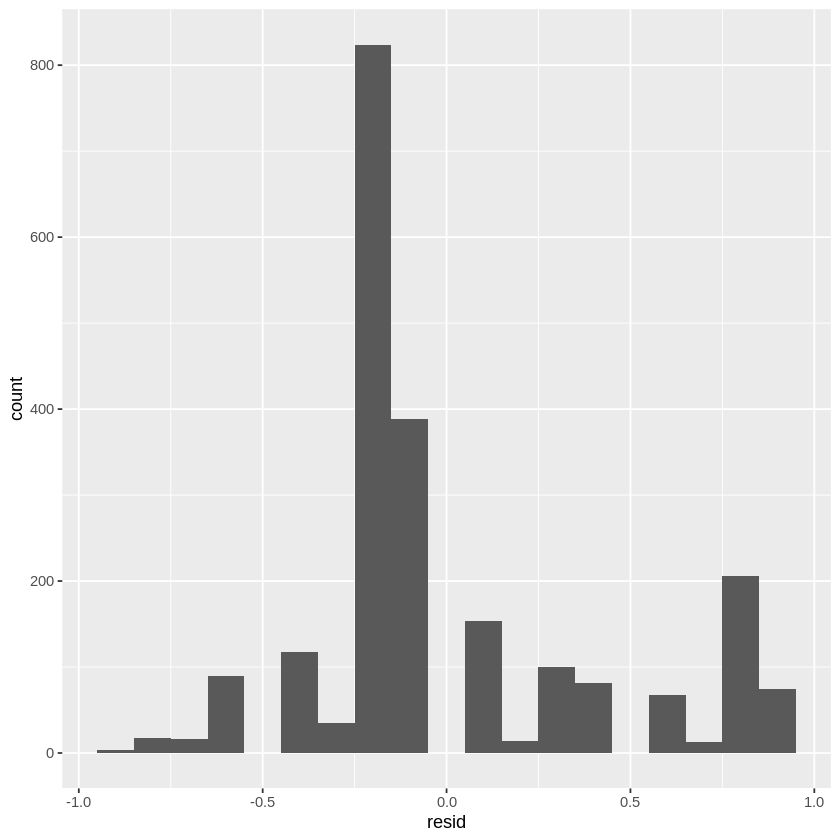

In [6]:
titanic_df %>% add_residuals(mdl) %>% mutate(resid=as.numeric(resid)) %>% 
    ggplot + geom_histogram(aes(x=resid), binwidth=.1)

What about predictions? The predicted outcomes are decimal numbers, whereas in the original model, the outcome was `TRUE` or `FALSE`.

In [7]:
titanic_df %>% add_predictions(mdl) %>% distinct %>% head

Class,Sex,Age,Survived,pred
<chr>,<chr>,<chr>,<lgl>,<dbl>
3rd,Male,Child,FALSE,0.2769110
3rd,Female,Child,FALSE,0.7675908
1st,Male,Adult,FALSE,0.4023497
2nd,Male,Adult,FALSE,0.2162696
3rd,Male,Adult,FALSE,0.0956153
Crew,Male,Adult,FALSE,0.2267959


The linear model says:

$$y = f(a + b x)$$ 

for $f(x)=x$. For 0/1 outcomes, let's instead try to think probabilistically:

$$\text{Prob}(y=1) = \underbrace{f(a + b x)}_{(\text{some function of the covariates})}$$

What criteria should this function $f$ have?
- It's range needs to be $[0,1]$.
- For "extreme" values of $a + bx$ it should tend to zero or one.

A function which satisfies both the properties is the **logistic function**:
$$f(x) = \frac{1}{1 + e^{-x}}.$$

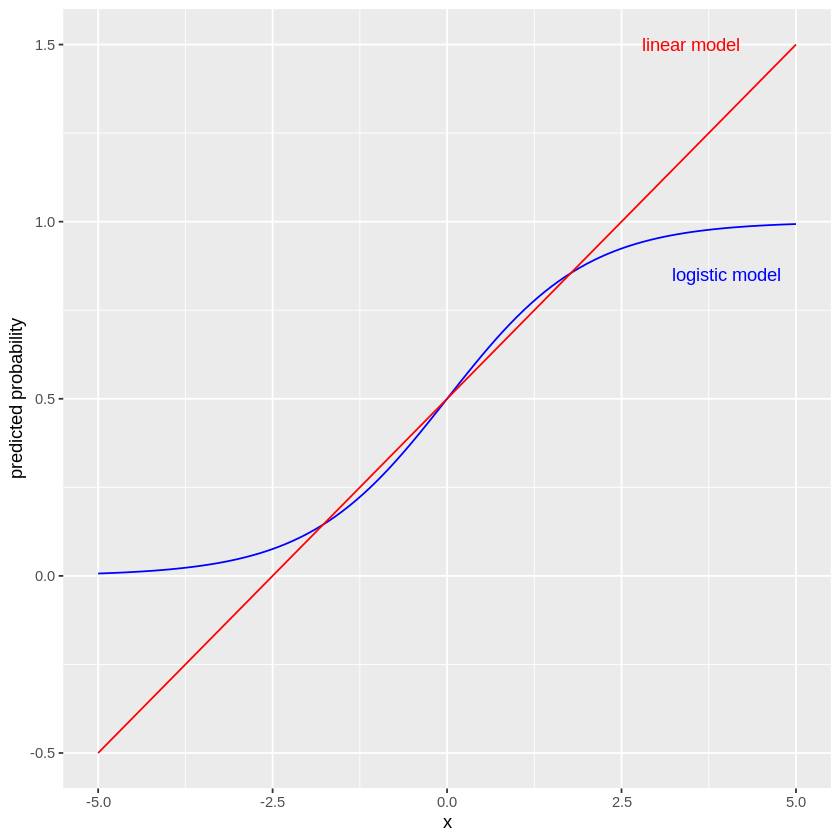

In [8]:
expand.grid(x=seq(-5, 5, .1)) %>% ggplot(aes(x=x)) + 
    stat_function(fun=function(x) (1 / (1 + exp(-x))), xlim=c(-5, 5), color="blue") +
    stat_function(fun=function(x) 1/2 + x/5, xlim=c(-5, 5), color="red") +
    annotate(x=3.5, y=1.5, geom="text", label="linear model", color="red") +
    annotate(x=4.0, y=.85, geom="text", label="logistic model", color="blue") + 
    ylab("predicted probability")

To fit this model in R, we use a similar command as for linear regression: `glm()`. (The "g" stands for **g**eneralized linear model.) We'll start as we did with linear regression, using a single predictor:

In [9]:
mdl <- glm(Survived ~ Sex, data = titanic_df, family = "binomial")
#                                             ^^^^^^ important
mdl


Call:  glm(formula = Survived ~ Sex, family = "binomial", data = titanic_df)

Coefficients:
(Intercept)      SexMale  
      1.004       -2.317  

Degrees of Freedom: 2200 Total (i.e. Null);  2199 Residual
Null Deviance:	    2769 
Residual Deviance: 2335 	AIC: 2339

Although these results look similar to linear regression, their interpretation is quite different. Specifically, they are interpreted in terms of their effect on the *log-odds ratio*.

 The model we estimated above is 
 
 $$\log \left( \frac{p}{1-p} \right) = a_0 + a_1 \cdot \{\text{Male}\}$$

where $p$ is now the probability that a passenger survived

Let's confirm this by calculating the percentage of male passengers that survived:

In [10]:
titanic_df %>% count(Sex, Survived)

Sex,Survived,n
<chr>,<lgl>,<int>
Female,FALSE,126
Female,TRUE,344
Male,FALSE,1364
Male,TRUE,367


In [11]:
367 / (1364 + 367)

344 / (126 + 344)

[1] 0.2120162

[1] 0.7319149

### The logistic function
The logistic function is $\sigma(x) = 1 / (1 + e^{-x})$. It is the inverse of the log-odds function:

$$\sigma \left( \log \frac{p}{1-p} \right) = p.$$

So, to calculate predicted probabilities from the log-odds, we apply the $\sigma(x)$ function to the predicted log-odds:

In [12]:
sigma <- function(x) 1 / (1 + exp(-x))
log.odds.female <- coef(mdl)[1]

log.odds.male <- sum(coef(mdl))

p.female <- sigma(log.odds.female)

p.male <- sigma(log.odds.male)

c(p.female, p.male)

(Intercept)             
  0.7319149   0.2120162

### Continuous predictor
Now let's consider logistic regression using a continuous predictor. To do this we'll download a richer version of this dataset which includes age as a number, instead of just classifying each passenger as adult or child:

In [13]:
titanic_df2 <- read_csv('https://raw.githubusercontent.com/datasciencedojo/datasets/master/titanic.csv')
titanic_df2 %>% print

Rows: 891 Columns: 12
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (5): Name, Sex, Ticket, Cabin, Embarked
dbl (7): PassengerId, Survived, Pclass, Age, SibSp, Parch, Fare

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


# A tibble: 891 × 12
   PassengerId Survived Pclass Name   Sex     Age SibSp Parch Ticket  Fare Cabin
         <dbl>    <dbl>  <dbl> <chr>  <chr> <dbl> <dbl> <dbl> <chr>  <dbl> <chr>
 1           1        0      3 Braun… male     22     1     0 A/5 2…  7.25 NA   
 2           2        1      1 Cumin… fema…    38     1     0 PC 17… 71.3  C85  
 3           3        1      3 Heikk… fema…    26     0     0 STON/…  7.92 NA   
 4           4        1      1 Futre… fema…    35     1     0 113803 53.1  C123 
 5           5        0      3 Allen… male     35     0     0 373450  8.05 NA   
 6           6        0      3 Moran… male     NA     0     0 330877  8.46 NA   
 7           7        0      1 McCar… male     54     0     0 17463  51.9  E46  
 8           8        0      3 Palss… male      2     3     1 349909 21.1  NA   
 9           9        1      3 Johns… fema…    27     0     2 347742 11.1  NA   
10          10        1      2 Nasse… fema…    14     1     0 237736 30.1  NA   
# ℹ 881

In [27]:
mdl <- glm(Survived ~ Age, data = titanic_df2, family = "binomial")
summary(mdl)


Call:
glm(formula = Survived ~ Age, family = "binomial", data = titanic_df2)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-1.1488  -1.0361  -0.9544   1.3159   1.5908  

Coefficients:
            Estimate Std. Error z value Pr(>|z|)  
(Intercept) -0.05672    0.17358  -0.327   0.7438  
Age         -0.01096    0.00533  -2.057   0.0397 *
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 964.52  on 713  degrees of freedom
Residual deviance: 960.23  on 712  degrees of freedom
  (177 observations deleted due to missingness)
AIC: 964.23

Number of Fisher Scoring iterations: 4


Now our regression model is

$$\log \left( \frac{p}{1-p} \right) = a_0 + a_1 \cdot \text{Age}.$$

## 🤔 Quiz

```
Call:
glm(formula = Survived ~ Age, family = "binomial")


Coefficients:
            Estimate Std. Error z value Pr(>|z|)  
(Intercept) -0.05672    0.17358  -0.327   0.7438  
Age         -0.01096    0.00533  -2.057   0.0397 *
```



According to the model, what is predicted probability that an 11-year old child survived the sinking of the Titanic?

<ol style="list-style-type: upper-alpha;">
    <li>&lt; 60%</li>
    <li>60-70%</li>
    <li>70-80%</li>
    <li>80-90%</li>
    <li>&gt; 90%</li>
</ol>

In [30]:
tibble(Age = 11) %>% add_predictions(mdl) %>% sigma

Age,pred
<dbl>,<dbl>
0.9999833,0.4557854


In [29]:
sigma(coef(mdl)[1] + 11 * coef(mdl)[2])


(Intercept) 
  0.4557854

### Logistic regression with multiple predictors

Just like with linear regression, multiple predictors can be added to logistic regression. The predicted log-odds becomes a multilinear function of the predictors:

$$\log \left( \frac{p}{1-p} \right) = a_0 + a_1 x_1 + \cdots + a_k x_k $$

In [15]:
mdl <- glm(Survived ~ Class + Age + Sex, data = titanic_df, family = "binomial")
#                                                           ^^^^^^ important! 
summary(mdl)


Call:
glm(formula = Survived ~ Class + Age + Sex, family = "binomial", 
    data = titanic_df)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-2.0812  -0.7149  -0.6656   0.6858   2.1278  

Coefficients:
            Estimate Std. Error z value Pr(>|z|)    
(Intercept)   2.0438     0.1679  12.171  < 2e-16 ***
Class2nd     -1.0181     0.1960  -5.194 2.05e-07 ***
Class3rd     -1.7778     0.1716 -10.362  < 2e-16 ***
ClassCrew    -0.8577     0.1573  -5.451 5.00e-08 ***
AgeChild      1.0615     0.2440   4.350 1.36e-05 ***
SexMale      -2.4201     0.1404 -17.236  < 2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 2769.5  on 2200  degrees of freedom
Residual deviance: 2210.1  on 2195  degrees of freedom
AIC: 2222.1

Number of Fisher Scoring iterations: 4


The model we are fitting here is:

$$\underbrace{ \log\left( \frac{p_\text{survival}}{1-p_\text{survival}}  \right)}_\text{log odds ratio} = 2.04-1.02\times\texttt{\{2nd class\}}+\cdots-2.42\times \texttt{male}$$

To be clear, the "model" for how the above data was generated is the following:
1. First, I use all the predictors to form the log-odds ratio. For example, for an adult, male, third-class passenger, the predicted log-odds ratio is:

In [16]:
titanic_df %>% add_predictions(mdl) %>% 
    filter(Class == "3rd", Sex == "Male", Age == "Adult") %>% head

Class,Sex,Age,Survived,pred
<chr>,<chr>,<chr>,<lgl>,<dbl>
3rd,Male,Adult,FALSE,-2.153985
3rd,Male,Adult,FALSE,-2.153985
3rd,Male,Adult,FALSE,-2.153985
3rd,Male,Adult,FALSE,-2.153985
3rd,Male,Adult,FALSE,-2.153985
3rd,Male,Adult,FALSE,-2.153985


2. The log-odds ratio is -2.153985. The predicted probability of survival is obtained by solving 

$$\log\left(\frac{p}{1-p}\right) = -2.153985$$ for $p$. 

To do this we apply the logistic function $f(x)=1/(1+e^{-x})$ to both sides:

$$p = \frac{1}{1 + \exp(2.153985)} = .104$$




### ROC curve
With multiple predictors, we can no longer easily visualize the logistic regression model as we did above. However, there is a very useful visualization for assessing its performance as a classifier called the receiver operating characteric (ROC) curve. To understand what this represents, let's add the predicted probabilities to our model:

In [17]:
titanic_pred <- titanic_df %>% 
  add_predictions(mdl, type = "response") %>% 
    print

# A tibble: 2,201 × 5
   Class Sex   Age   Survived  pred
   <chr> <chr> <chr> <lgl>    <dbl>
 1 3rd   Male  Child FALSE    0.251
 2 3rd   Male  Child FALSE    0.251
 3 3rd   Male  Child FALSE    0.251
 4 3rd   Male  Child FALSE    0.251
 5 3rd   Male  Child FALSE    0.251
 6 3rd   Male  Child FALSE    0.251
 7 3rd   Male  Child FALSE    0.251
 8 3rd   Male  Child FALSE    0.251
 9 3rd   Male  Child FALSE    0.251
10 3rd   Male  Child FALSE    0.251
# ℹ 2,191 more rows


The output of logistic regression is a set of _probabilities_ (numbers between 0 and 1), whereas the observed value is either 0 or 1. To convert from probabilities to prediction of 0 or 1, most of use would probably use the common sense rule

> Predict that Survived=1 if the predicted probability of survival is > 1/2.

In [18]:
titanic_pred %>% mutate(Survived_hat = as.integer(pred > 1/2)) %>% head

Class,Sex,Age,Survived,pred,Survived_hat
<chr>,<chr>,<chr>,<lgl>,<dbl>,<int>
3rd,Male,Child,FALSE,0.2511586,0
3rd,Male,Child,FALSE,0.2511586,0
3rd,Male,Child,FALSE,0.2511586,0
3rd,Male,Child,FALSE,0.2511586,0
3rd,Male,Child,FALSE,0.2511586,0
3rd,Male,Child,FALSE,0.2511586,0



<img src='https://ebooks.mobibootcamp.com/ml_ai/confusion_matrix.png' />


To evaluate our classifier we'll think about 2 measures:

- True positive rate: The percentage of people who are predicted to survive who in fact survived.
- False positive rate: The percentage of people who are predicted to survive who in fact perished.


In [19]:
titanic_pred %>% mutate(
    Survived_hat = pred > .4,
    Perished = !Survived, 
    Perished_hat = !Survived_hat,
    tn = Perished_hat & Perished,  # true -
    tp = Survived & Survived_hat,  # true +
    fp = Survived_hat & Perished,  # false +
    fn = Perished_hat & Survived   # false -
) %>% summarize(
    fpr = sum(fp) / (sum(fp) + sum(tn)),  # fraction of true - incorrectly classified as +,
    tpr = sum(tp) / (sum(tp) + sum(fn))  # fraction of true + correctly classified as +
)

fpr,tpr
<dbl>,<dbl>
0.1637584,0.5864979


When we choose an extreme high value of the threshold, our classification rule always predicts `Survival = 0`, it has a false-positive rate of zero. This is good; we want our classifier to make as few false-positive predictions as possible. 

However, it also has a true positive rate of zero! So it has no power to correctly predict that any of the true survivors in fact survived.

Conversely, when we choose an extremely low value, it always predicts survival, so `TPR = FPR = 1`.

From the preceding discussion, we see that, given any probabilistic classifier, we can always make it have $\text{FPR}=\text{TPR}=1$ or $\text{FPR}=\text{TPR}=0$ by choosing an extreme probability cutoff. In other words, there is a tradeoff between having a good (i.e. close to zero) false-positive rate and a good (i.e. close to 1) true positive rate.

The ROC curve is a visual summary of this tradeoff. It plots the false positive rate on the $x$-axis, and the true positive rate on the $y$ axis. 

In [23]:
install.packages("ROCR")

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘bitops’, ‘gtools’, ‘caTools’, ‘gplots’




ERROR: ignored

In [24]:
library(ROCR)
roc <- titanic_pred %>% roc_curve(factor(!Survived), pred)
autoplot(roc)

ERROR: ignored

### Area under curve
A useful summary of the ROC curve is the area under the curve (AUC), which ranges between 1/2 and 1. A classifier that has AUC=1 can perfectly classify the data since it achieves TPR=1 and FPR=0.

## Who will win?
![image.png](attachment:image.png)
Tonight is the final game of March Madness: UConn will play San Diego State for the national championship. Who will win the game? Given some data about each team, can we build a statistical model that predicts who will win?

In [ ]:
load(url('https://datasets.stats306.org/ncaa.RData'))

This command loads three tables:
- `ncaa_games`: outcomes of every game from 2002-2018.
- `ncaa_players`: all players and their stats for the same time period.
- `ncaa_schools`: table mapping schools to their numerical ID.

In [ ]:
ncaa_games %>% head

In [ ]:
ncaa_schools %>% filter(school_id %in% c(1390, 26172))

In [ ]:
ncaa_players %>% head

In [ ]:
ncaa_players[1,] %>% t

For this analysis, we will summarize each team by simply averaging the stats of each player on the team for that year:

In [ ]:
school_stats <- ncaa_players %>% 
    group_by(school_id, year) %>% 
    summarize(across(where(is.double), \(x) mean(x, na.rm = T))) %>% 
    select(-c(dd, td, turnovers))  # these are missing for almost every player/team

Next, we need to create the data frame that we will use to train our model. This means joining data for each pair of teams that played in each game. Note that each game is represented twice in the dataset, with each team being called "opponent", e.g.:

In [ ]:
ncaa_games %>% filter(game_date == "2001-11-16", school_id == 26172 | opponent_id == 26172)

Now we perform the join. (To make things go faster we are going to downsample the data to only 30,000 games.)

In [ ]:
ncaa_data <- ncaa_games %>% sample_n(30000) %>% inner_join(school_stats) %>% 
    inner_join(school_stats, join_by(opponent_id == school_id, year), suffix = c("", "_opponent")) %>% 
    mutate(win = score > opponent_score) 

### Selecting a good model
Last lecture, we saw how to create large, rich regression models by including more and more predictors into our regression. But we also saw that this could actually decrease predictive accuracy when analyzing data that the model had never seen before. 

Now, we will learn ways to systematically find a good model by dividing our data and using out-of-sample predictive performance to guide model selection.

The first step will be to divide our data into two sets, training and test.
- We will use the **training** set to train our model, and then
- The **testing** set will be used to judge how accurate it is on new data.

In [ ]:
ncaa_split <- ncaa_data %>% 
    select(win, where(is.double), location, attendence, -game_date) %>% 
    filter(complete.cases(.)) %>% 
    initial_split(prop = .9)
training(ncaa_split) %>% glimpse
testing(ncaa_split) %>% glimpse

Let's try fitting the logistic regression model to this data set, and measure its performance using cross-entropy loss:

In [ ]:
mdl <- glm(win ~ (height + g + fg_made + rebounds_avg + height_opponent + fg_made_opponent)^2,
                  data = training(ncaa_split), family = "binomial")

In [ ]:
summary(mdl)

### Cross-entropy loss

Now let's define what it means for a binary prediction to be good. For a binary variable $y \in \{0, 1\}$ with predicted value $\hat{y} \in [0, 1]$, the *cross-entropy loss* is defined as 

$$ -y \log(\hat{y}) - (1 - y) \log(1 - \hat{y}) $$

(lower is better)

In [ ]:
cross.entropy <- function(y, yhat) {
    -y * log(yhat) - (1 - y) * log1p(-yhat)
}

In [ ]:
training(ncaa_split) %>% add_predictions(mdl, type = "response") %>% 
    mutate(loss = cross.entropy(win, pred)) %>% summarize(mean(loss, na.rm = T))

## Automatic model selection
Next, we will use the `tidymodels` packing to automate the process of finding a good model. First, we tell tidymodels that we want to perform logistic regression:

In [ ]:
lr_mod <- 
  logistic_reg(penalty = tune(), mixture = 1) %>% 
  set_engine("glmnet")

Next, we create a "recipe" that tells tidymodels how to set up the data for our prediction problem.

In [ ]:
lr_recipe <- recipe(win ~ ., data = ncaa_split) %>% 
    step_bin2factor(win) %>% 
    step_dummy(location)

In [ ]:
lr_workflow <- 
  workflow() %>% 
  add_model(lr_mod) %>% 
  add_recipe(lr_recipe)

In [ ]:
val_set <- validation_split(training(ncaa_split))
lr_reg_grid <- tibble(penalty = 10^seq(-4, -1, length.out = 30))
lr_res <- 
  lr_workflow %>% 
  tune_grid(val_set,
            grid = lr_reg_grid,
            control = control_grid(save_pred = TRUE),
            metrics = metric_set(roc_auc))

In [ ]:
lr_res

In [ ]:
## A different algorithm

In [ ]:
rf_mod <- 
  rand_forest(mtry = tune(), min_n = tune(), trees = 1000) %>% 
  set_engine("ranger", num.threads = cores) %>% 
  set_mode("classification")